# **Imports/ Dependencies**

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from scipy.stats import f
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from scipy.signal import savgol_filter
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
import requests


# **Load the Dataset**

In [3]:
def load_data():
  # Load dataset from the GitHub Repo
  github_file_url = "https://raw.githubusercontent.com/Madhavi96/ml-modelling-for-biomass-characterization/main/NIR_Data.xlsx"

  # Download the file
  file_path = "/content/NIR_Data.xlsx"
  response = requests.get(github_file_url)

  # Save the file locally
  with open(file_path, "wb") as file:
      file.write(response.content)

  # Load dataset from the specified sheet
  df = pd.read_excel(file_path, sheet_name="NIR Spectra_Predictors")

  # Data cleaning: Remove unnecessary columns
  df_clean = df.iloc[:, 2:]  # Remove Sample ID and unnamed column

  # Separate features and target
  X = df_clean.drop(columns=["Moisture"]).to_numpy()
  y = df_clean["Moisture"].to_numpy()

  # Extract feature names (wavelengths)
  wl = [col for col in df_clean.columns if col != "Moisture"]
  wl = np.array(wl, dtype=float)  # Ensure it's a numeric array

  return X, y, wl

# Example usage
X, y, wl = load_data()

# **Exploratory Data Analysis (EDA)**

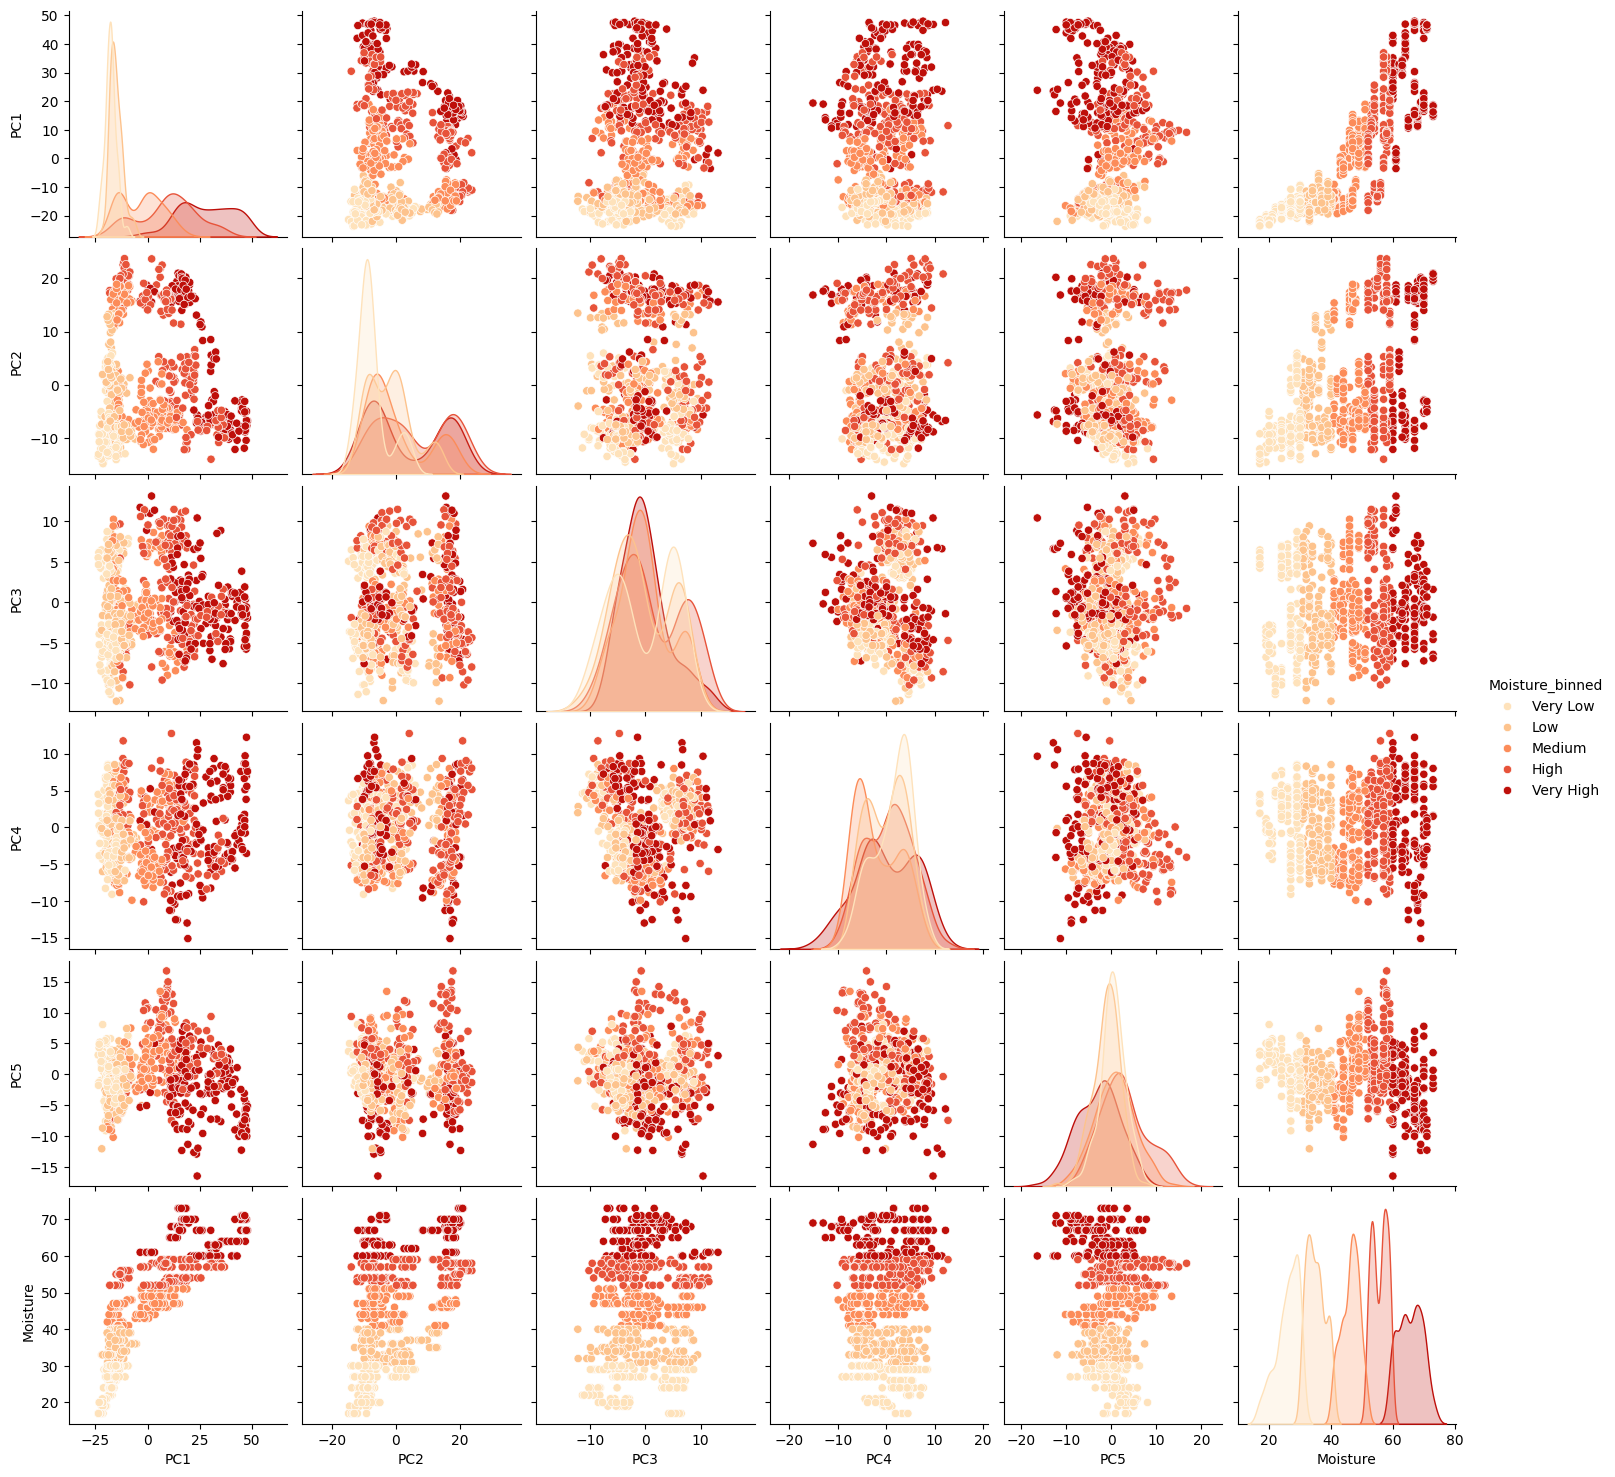

In [4]:
X2 = savgol_filter(X, 11, polyorder = 2,deriv=2)
pca = PCA(n_components=5)
Xs = StandardScaler().fit_transform(X2)
Xpca = pca.fit_transform(Xs)


df = pd.DataFrame(Xpca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
df["Moisture"] = y.T.astype("int")
df['Moisture_binned'] = pd.qcut(df['Moisture'], q=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])
sns.pairplot(df, hue='Moisture_binned', palette='OrRd')
plt.show()


*   **PC1 shows high-correlation with the target variable - Moisture, due to the high upward trend**

*   **The remaining Principle Components do not show strong correlations with the target variable**






# **Data Preprocessing**

# **1. Outlier Detection**




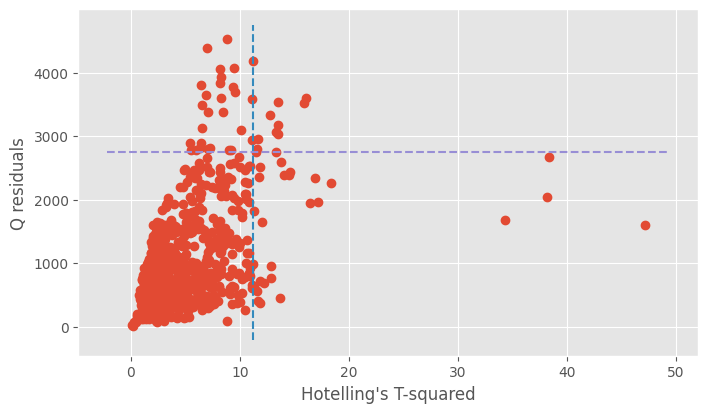

In [4]:
ncomp = 5
X2 = savgol_filter(X, 21, polyorder = 6,deriv=2)

# Define PLS object
pls = PLSRegression(n_components=ncomp)
pls.fit(X, y)

# Get X scores
T = pls.x_scores_
# Get X loadings
P = pls.x_loadings_

# Calculate error array
Err = X2 - np.dot(T,P.T)

# Calculate Q-residuals (sum over the rows of the error array)
Q = np.sum(Err**2, axis=1)

# Calculate Hotelling's T-squared
Tsq = np.sum((pls.x_scores_/np.std(pls.x_scores_, axis=0))**2, axis=1)
conf = 0.95

# Calculate confidence level for T-squared from the ppf of the F distribution
Tsq_conf =  f.ppf(q=conf, dfn=ncomp, \
            dfd=(X2.shape[0]-ncomp))*ncomp*(X2.shape[0]-1)/(X2.shape[0]-ncomp)

# Estimate the confidence level for the Q-residuals
i = np.max(Q)+1
while 1-np.sum(Q>i)/np.sum(Q>0)> conf:
    i -= 1
Q_conf = i

ax = plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(Tsq, Q, 'o')

    plt.plot([Tsq_conf,Tsq_conf],[plt.axis()[2],plt.axis()[3]],  '--')
    plt.plot([plt.axis()[0],plt.axis()[1]],[Q_conf,Q_conf],  '--')
    plt.xlabel("Hotelling's T-squared")
    plt.ylabel('Q residuals')

plt.show()




*   **Points with large Q-residuals are the ones that are not well explained by the calibration model. Points with large Hotelling’s T-squared values are instead those who display deviations within the model.**



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter

# Plot CV results before and after outlier removal
def plot_cv_results(y_true, y_pred, title="CV Results"):
    plt.figure(figsize=(8, 4.5))
    plt.scatter(y_true, y_pred, color='red', edgecolors='black', alpha=0.7)

    # Best-fit line
    coeffs = np.polyfit(y_true, y_pred, 1)
    poly_eq = np.poly1d(coeffs)
    plt.plot(y_true, poly_eq(y_true), color='blue', label="Best Fit")

    # Reference y=x line
    plt.plot(y_true, y_true, color='green', label="Ideal Fit")

    # Compute evaluation metrics
    r2 = r2_score(y_true, y_pred)
    mse_val = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse_val)
    bias = np.mean(y_pred - y_true)

    # Display metrics
    metrics_text = f"R² (CV) = {r2:.3f}\nMSE (CV): {mse_val:.3f}\nRMSE (CV): {rmse:.3f}\nBias (CV): {bias:.3f}"

    plt.text(80, max(y_pred)/2, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    plt.xlabel("Measured")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return r2, rmse, bias

def remove_outliers_and_optimize(X, y, Q, Tsq, model, max_outliers=70, model_params=None):
    """
    Removes outliers iteratively to minimize cross-validation error.

    Parameters:
    - X: Feature matrix
    - y: Target variable
    - Q: Q statistic (for detecting outliers)
    - Tsq: T² statistic (for detecting outliers)
    - model: Machine learning model (PLSRegression, SVR, or MLPRegressor)
    - max_outliers: Maximum number of outliers to remove
    - model_params: Dictionary of parameters for the model

    Returns:
    - X_cleaned: Feature matrix after removing optimal outliers
    - y_cleaned: Target values after removing optimal outliers
    - trained_model: Model trained on cleaned data
    """

    # Compute RMS distance and sort in descending order
    rms_dist = np.flip(np.argsort(np.sqrt(Q**2 + Tsq**2)), axis=0)

    # Sort data accordingly
    Xc = X[rms_dist, :]
    Yc = y[rms_dist]

    # Store MSE values
    mse = np.zeros(max_outliers)

    # Iteratively remove outliers and calculate cross-validation MSE
    for j in tqdm(range(max_outliers)):
        current_model = model(**model_params) if model_params else model()
        current_model.fit(Xc[j:, :], Yc[j:])
        y_cv = cross_val_predict(current_model, Xc[j:, :], Yc[j:], cv=5)
        mse[j] = mean_squared_error(Yc[j:], y_cv)

    # Find the optimal number of outliers to remove
    optimal_outliers = np.argmin(mse[np.nonzero(mse)])

    # Remove the optimal number of outliers
    X_cleaned = Xc[optimal_outliers:, :]
    y_cleaned = Yc[optimal_outliers:]

    # Retrain the model on cleaned data
    trained_model = model(**model_params) if model_params else model()
    trained_model.fit(X_cleaned, y_cleaned)
    y_pred_cleaned = cross_val_predict(trained_model, X_cleaned, y_cleaned, cv=5)

    # Plot MSE vs. number of outliers removed
    plt.figure(figsize=(8, 4.5))
    plt.plot(range(max_outliers), mse, marker='o', linestyle='-')
    plt.axvline(optimal_outliers, color='red', linestyle='--', label=f'Optimal = {optimal_outliers}')
    plt.xlabel("Number of Outliers Removed")
    plt.ylabel("MSE (Cross-Validation)")
    plt.title("MSE vs. Number of Outliers Removed")
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_cv_results(Yc, cross_val_predict(model(**model_params) if model_params else model(), Xc, Yc, cv=5), title="Before Outlier Removal")
    r2, rmse, bias = plot_cv_results(y_cleaned, y_pred_cleaned, title="After Outlier Removal")

    return X_cleaned, y_cleaned, trained_model, r2, rmse, bias


100%|██████████| 70/70 [00:29<00:00,  2.39it/s]


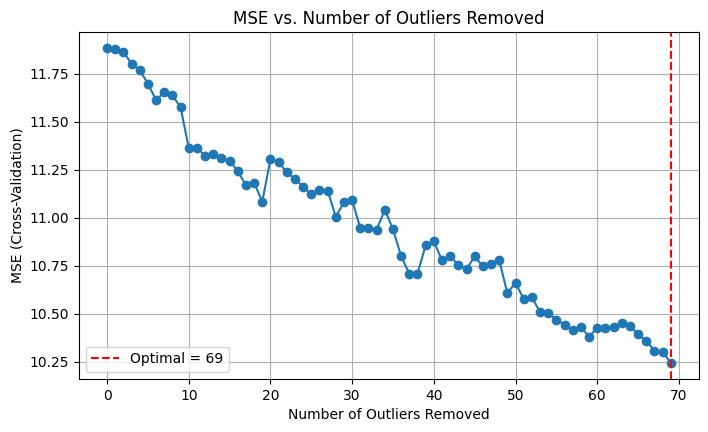

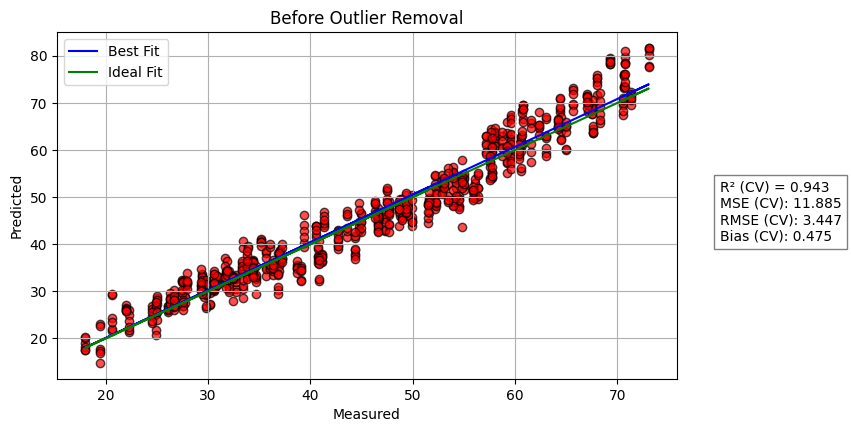

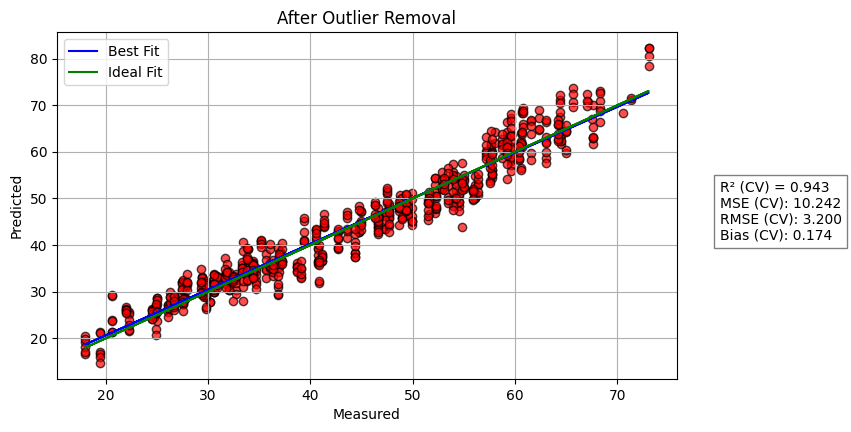

In [6]:
X_cleaned, y_cleaned, pls_model, r2, rmse, bias = remove_outliers_and_optimize(
    X, y, Q, Tsq,
    model=PLSRegression,
    max_outliers=70,
    model_params={"n_components": 14}
)

100%|██████████| 70/70 [01:55<00:00,  1.66s/it]


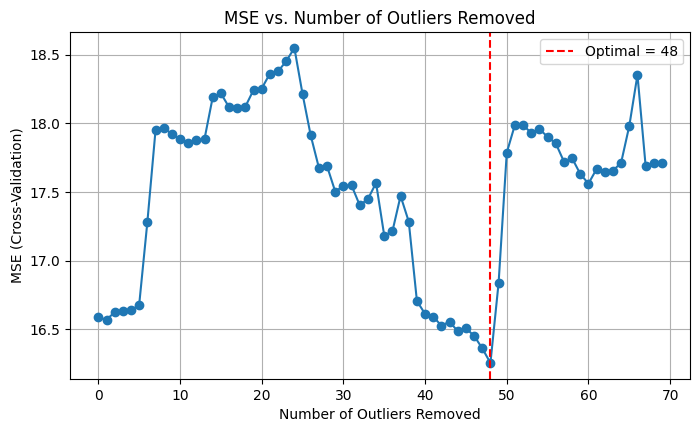

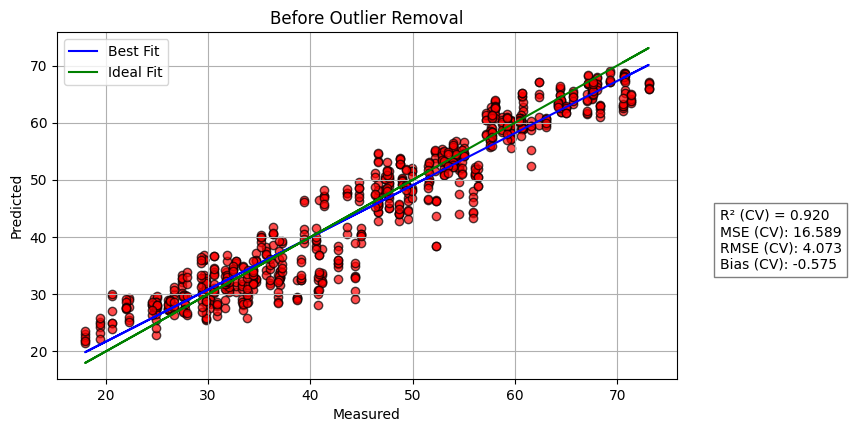

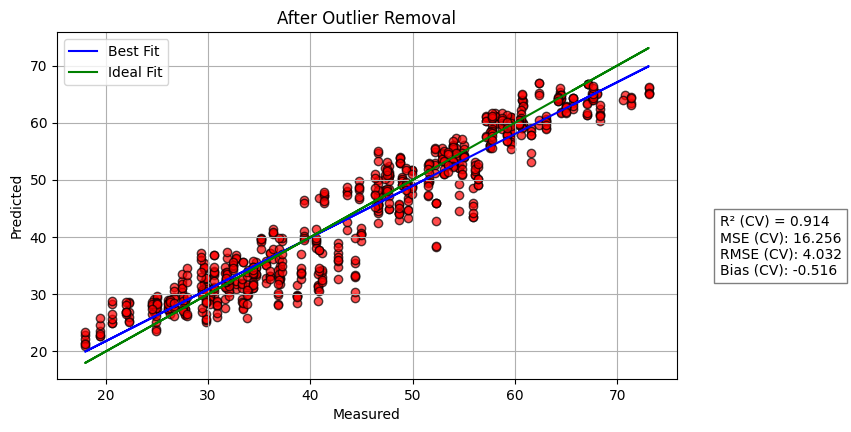

In [7]:
X_cleaned, y_cleaned, svr_model, r2, rmse, bias = remove_outliers_and_optimize(
    X, y, Q, Tsq,
    model=SVR,
    max_outliers=70,
    model_params={"kernel": "rbf", "C": 100, "epsilon": 0.01}
)

100%|██████████| 35/35 [19:47<00:00, 33.93s/it]


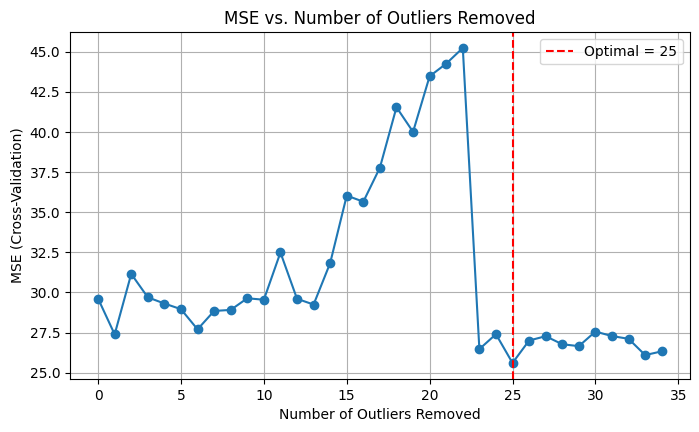

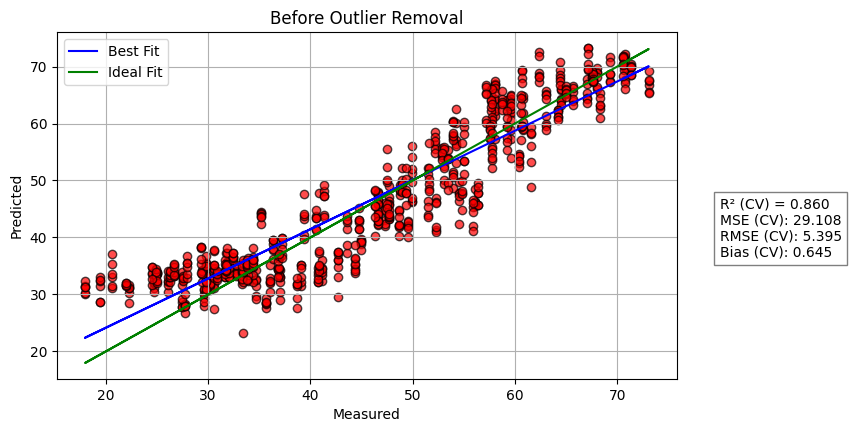

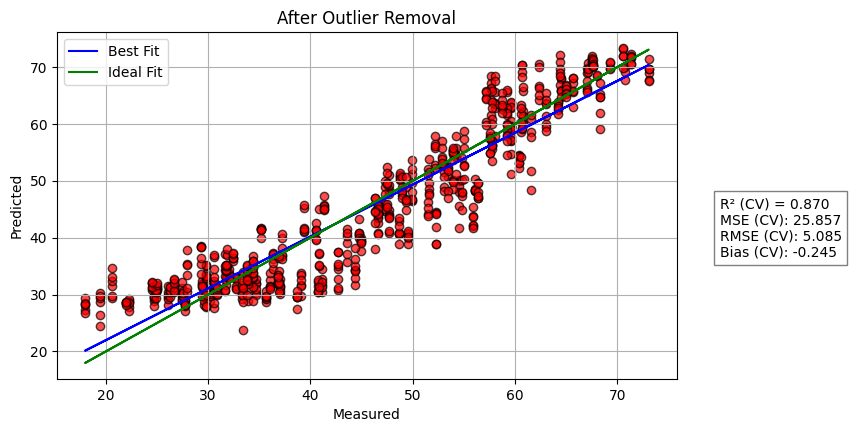

In [8]:
X_cleaned, y_cleaned, ann_model, r2, rmse, bias = remove_outliers_and_optimize(
    X, y, Q, Tsq,
    model=MLPRegressor,
    max_outliers=35,
    model_params={"hidden_layer_sizes": (100, 100), "max_iter": 1000, "solver": "adam"}
)

# **2. Smoothing**

## 2.1. plot original distribution

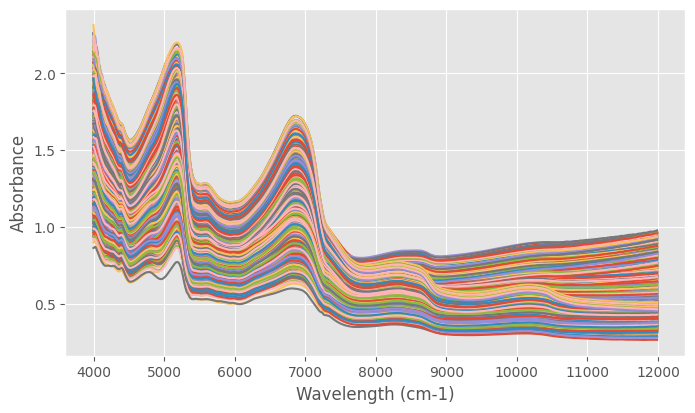

In [9]:
X, y, wl = load_data()

# Plot original data
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X.T)
    plt.xlabel('Wavelength (cm-1)')
    plt.ylabel('Absorbance')
    plt.show()

## 2.2 plot distribution after applying different sv-gol filters

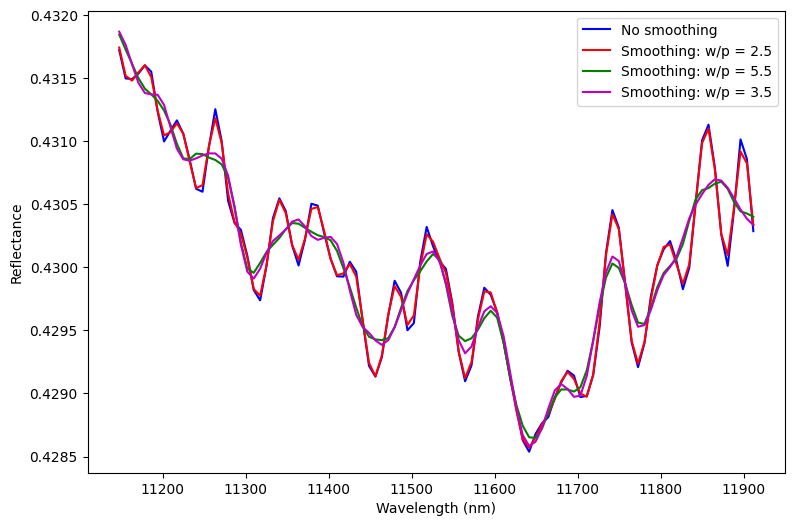

In [10]:
# Apply Savitzky-Golay filter
w = 5  # Window size
p = 2  # Polynomial order
X_smooth_1 = savgol_filter(X, w, polyorder=p, deriv=0, axis=1)
X_smooth_2 = savgol_filter(X, 2*w+1, polyorder=p, deriv=0, axis=1)
X_smooth_3 = savgol_filter(X, 4*w+1, polyorder=3*p, deriv=0, axis=1)

# Select a valid range of wavelengths to plot
num_features = X.shape[1]  # Number of wavelength points
interval = np.arange(10, min(110, num_features))  # Adjust if needed

plt.figure(figsize=(9, 6))
plt.plot(wl[interval], X[0, interval], 'b', label='No smoothing')
plt.plot(wl[interval], X_smooth_1[0, interval], 'r', label='Smoothing: w/p = 2.5')
plt.plot(wl[interval], X_smooth_2[0, interval], 'g', label='Smoothing: w/p = 5.5')
plt.plot(wl[interval], X_smooth_3[0, interval], 'm', label='Smoothing: w/p = 3.5')

plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.show()


*   The magenta line in the figure above, smooths out the noise oscillation pretty well, yet it follows the peak trough more closely - This suggests a good smoothing function.

## 2.3 Apply the best parameters in the SV-GOL Smoothing filter

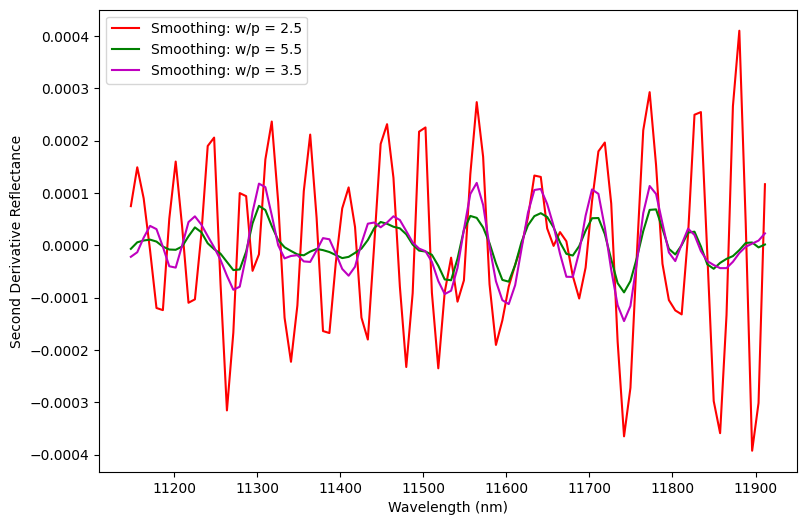

In [11]:
# Apply Savitzky-Golay filter
w = 5  # Window size
p = 2  # Polynomial order
X_smooth_1 = savgol_filter(X, w, polyorder=p, deriv=2, axis=1)
X_smooth_2 = savgol_filter(X, 2*w+1, polyorder=p, deriv=2, axis=1)
X_smooth_3 = savgol_filter(X, 4*w+1, polyorder=3*p, deriv=2, axis=1)

# Select a valid range of wavelengths to plot
num_features = X.shape[1]  # Number of wavelength points
interval = np.arange(10, min(110, num_features))  # Adjust if needed

plt.figure(figsize=(9, 6))
# plt.plot(wl[interval], X[0, interval], 'b', label='No smoothing')
plt.plot(wl[interval], X_smooth_1[0, interval], 'r', label='Smoothing: w/p = 2.5')
plt.plot(wl[interval], X_smooth_2[0, interval], 'g', label='Smoothing: w/p = 5.5')
plt.plot(wl[interval], X_smooth_3[0, interval], 'm', label='Smoothing: w/p = 3.5')

plt.xlabel("Wavelength (nm)")
plt.ylabel("Second Derivative Reflectance")
plt.legend()
plt.show()




*   Even if the second derivative values are plotted, we can see that the mild smoothing (in red) is quite ineffective. The red curve is still significantly noisy.
*   The green curve is arguably too smooth instead. The contrast of the main features is quite reduced as a result of the large window.
*   Once again the parameters used for the magenta line are better.



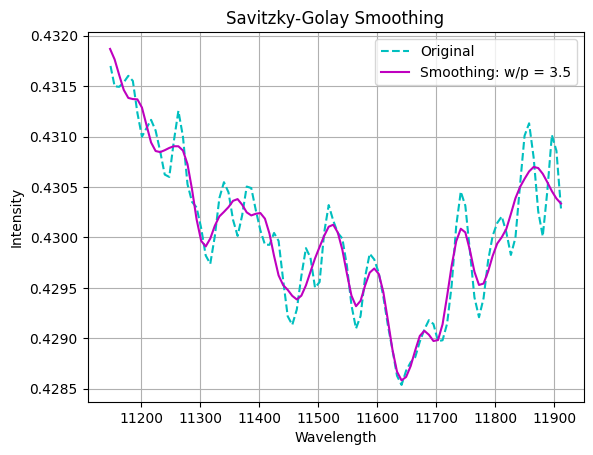

In [12]:
def sv_gol_smoothing(X, window_size, polyorder, wl=None, interval=None, plot = False):
    """
    Apply Savitzky-Golay smoothing filter to input data.

    Parameters:
    - X: ndarray
        Input data (e.g., spectral data).
    - w: int, optional (default=5)
        Window size for smoothing.
    - p: int, optional (default=2)
        Polynomial order.
    - wl: ndarray, optional
        Wavelength or x-axis values for plotting.
    - interval: slice or list, optional
        Interval of data to plot.

    Returns:
    - X_smooth: ndarray
        Smoothed version of X.
    """
    # Ensure window size is odd

    # Apply Savitzky-Golay filter
    X_smooth = savgol_filter(X, window_size, polyorder, deriv=0, axis=1)

    # Plot results if wl and interval are provided
    if wl is not None and interval is not None and plot:
        plt.plot(wl[interval], X[0, interval], 'c--', label='Original')
        plt.plot(wl[interval], X_smooth[0, interval], 'm', label=f'Smoothing: w/p = 3.5')
        plt.xlabel("Wavelength")
        plt.ylabel("Intensity")
        plt.legend()
        plt.title("Savitzky-Golay Smoothing")
        plt.grid(True)
        plt.show()

    return X_smooth

# Example usage:
X_smoothed = sv_gol_smoothing(X, window_size=21, polyorder=6, wl=wl, interval=np.arange(10, min(110, X.shape[1])), plot = True)

# **3. Scatter Correction**

## 3.1. Standard Normal Variate (SNV)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def snv_correction(input_data, wl=None):
    """
    Apply Standard Normal Variate (SNV) correction to input spectral data.

    Parameters:
    - input_data: ndarray
        The spectral data to be corrected (shape: samples x features).
    - wl: ndarray, optional
        Wavelength values for plotting.

    Returns:
    - output_data: ndarray
        Scatter-corrected spectral data.
    """

    # Compute mean and standard deviation along each row (sample-wise)
    mean = np.mean(input_data, axis=1, keepdims=True)
    std = np.std(input_data, axis=1, keepdims=True)

    # Apply SNV transformation
    output_data = (input_data - mean) / std

    # Compute SNV transformation
    # Define a new array and populate it with the corrected data
    # output_data = np.zeros_like(input_data)
    # print(input_data.shape)
    # for i in range(input_data.shape[0]):

    #     # Apply correction
    #     output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])


    # output_data = (input_data - np.mean(input_data, axis=1, keepdims=True)) / np.std(input_data, axis=1, keepdims=True)

    # Plot results if wavelength values are provided
    if wl is not None:
        plt.figure(figsize=(12, 6))
        with plt.style.context('ggplot'):
            plt.plot(wl, output_data.T, alpha=0.7)
            plt.xlabel('Wavelength')
            plt.ylabel('SNV Corrected')
            plt.title('SNV Scatter Correction')
            plt.grid(True)
        plt.show()

    return output_data

# Example usage:
# X_snv = snv_correction(X, wl=wl)


## 3.2 Multiplicative Scatter Correction (MSC)

In [14]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''

    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate it from the mean
    if reference is None:
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference

    # Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0]

    # Plot results
    plt.figure(figsize=(12, 6))
    with plt.style.context('ggplot'):
        plt.plot(wl, data_msc.T, alpha=0.7)
        plt.xlabel('Wavelength')
        plt.ylabel('MSC Corrected')
        plt.title('MSC Scatter Correction')
        plt.grid(True)
    plt.show()

    return (data_msc, ref)

## 3.3 Extended Inverse - PVM Version (EI-PVM) Correction

In [15]:
def ei_pvm(X, n_components=5):
    """
    Extended Inverse - PVM Version (EI-PVM) Preprocessing for NIR Spectroscopy.

    Parameters:
    X : numpy.ndarray
        The spectral dataset (samples × wavelengths).
    n_components : int
        Number of principal components used for modeling scatter effects.

    Returns:
    X_corrected : numpy.ndarray
        Scatter-corrected spectral data.
    """

    # Step 1: Apply PCA to extract primary spectral variations
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_pca = pca.transform(X)  # Project original data into PCA space

    # Step 2: Reconstruct spectral data using selected principal components
    X_reconstructed = pca.inverse_transform(X_pca)

    # Step 3: Compute the scatter correction factor
    scatter_correction = X_reconstructed / np.mean(X_reconstructed, axis=0)

    # Step 4: Apply scatter correction to original spectra
    X_corrected = X / scatter_correction

    # Select a valid range of wavelengths to plot
    num_features = X.shape[1]  # Number of wavelength points
    interval = np.arange(10, min(1100, num_features))  # Ensure within valid range

    # Plot EI-PVM processed data for the same interval
    plt.figure(figsize=(9, 6))
    plt.plot(wl[interval], X[0, interval], '--', label='Raw Spectrum', alpha=0.6)
    plt.plot(wl[interval], X_corrected[0, interval], 'r', label='EI-PVM Processed Spectrum')

    plt.xlabel("Wavelength (cm-1)")
    plt.ylabel("Reflectance")
    plt.legend()
    plt.title("EI-PVM Preprocessing on NIR Spectra")
    plt.show()

    return X_corrected

# **Modelling**

In [16]:
# Initialize an empty dictionary to store model results
results = []

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np



def store_model_results(model_name, r2_svgol, rmse_svgol, bias_svgol,
                        r2_snv, rmse_snv, bias_snv,
                        r2_msc, rmse_msc, bias_msc):
    """
    Stores the results of the model's performance in the 'results' dictionary.
    """

    # Store the results
    results.append({
        "model_name": model_name,
        "r2_svgol": r2_svgol,
        "rmse_svgol": rmse_svgol,
        "bias_svgol": bias_svgol,
        "r2_snv": r2_snv,
        "rmse_snv": rmse_snv,
        "bias_snv": bias_snv,
        "r2_msc": r2_msc,
        "rmse_msc": rmse_msc,
        "bias_msc": bias_msc
    })

def compare_results(results):
    """
    Compare and plot results for multiple models with their performance metrics (R2, RMSE, Bias)
    for SV-Gol, SNV, and MSC corrections.

    Parameters:
    - results: A list of dictionaries containing model results with 'r2_svgol', 'rmse_svgol', 'bias_svgol',
               'r2_snv', 'rmse_snv', 'bias_snv', 'r2_msc', 'rmse_msc', 'bias_msc'.
    """

    # Initialize lists to store values for the plots
    model_names = [result["model_name"] for result in results]
    r2_svgol = [result["r2_svgol"] for result in results]
    rmse_svgol = [result["rmse_svgol"] for result in results]
    bias_svgol = [result["bias_svgol"] for result in results]

    r2_snv = [result["r2_snv"] for result in results]
    rmse_snv = [result["rmse_snv"] for result in results]
    bias_snv = [result["bias_snv"] for result in results]

    r2_msc = [result["r2_msc"] for result in results]
    rmse_msc = [result["rmse_msc"] for result in results]
    bias_msc = [result["bias_msc"] for result in results]

    # Set the width of the bars
    bar_width = 0.25
    index = np.arange(len(results))  # Set the x positions for the bars

    # Create subplots
    fig, ax = plt.subplots(3, 1, figsize=(10, 18))  # Three plots for r2, rmse, and bias

    # Plot R2 results
    ax[0].bar(index - bar_width, r2_svgol, bar_width, label='SV-Gol', color='skyblue')
    ax[0].bar(index, r2_snv, bar_width, label='SNV', color='orange')
    ax[0].bar(index + bar_width, r2_msc, bar_width, label='MSC', color='green')
    ax[0].set_title('R2 Comparison')
    ax[0].set_xticks(index)
    ax[0].set_xticklabels(model_names, rotation=45)
    ax[0].set_ylabel('R2')
    ax[0].legend()

    # Plot RMSE results
    ax[1].bar(index - bar_width, rmse_svgol, bar_width, label='SV-Gol', color='skyblue')
    ax[1].bar(index, rmse_snv, bar_width, label='SNV', color='orange')
    ax[1].bar(index + bar_width, rmse_msc, bar_width, label='MSC', color='green')
    ax[1].set_title('RMSE Comparison')
    ax[1].set_xticks(index)
    ax[1].set_xticklabels(model_names, rotation=45)
    ax[1].set_ylabel('RMSE')
    ax[1].legend()

    # Plot Bias results
    ax[2].bar(index - bar_width, bias_svgol, bar_width, label='SV-Gol', color='skyblue')
    ax[2].bar(index, bias_snv, bar_width, label='SNV', color='orange')
    ax[2].bar(index + bar_width, bias_msc, bar_width, label='MSC', color='green')
    ax[2].set_title('Bias Comparison')
    ax[2].set_xticks(index)
    ax[2].set_xticklabels(model_names, rotation=45)
    ax[2].set_ylabel('Bias')
    ax[2].legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


In [18]:
def process_and_train_model(X, y, wl, model_name, model, model_params=None):
    """
    This function applies preprocessing (smoothing, outlier removal, scatter correction), scales features,
    trains the model, and plots the cross-validation results.

    Parameters:
    - X: Features
    - y: Target variable
    - wl: Wavelengths or feature names
    - model: The machine learning model to use
    - model_params: Dictionary of parameters for the model
    - title: Title for the performance plot
    """

    # Hardcoded parameters for SV-Gol Smoothing
    window_size = 21
    polyorder = 6
    interval = np.arange(10, min(110, X.shape[1]))  # This may depend on your data

    # Hardcoded parameters for outlier removal and PLS regression
    max_outliers = 70
    n_components = 14

    # Apply SV-Gol Smoothing
    X_smoothed = sv_gol_smoothing(X, window_size=window_size, polyorder=polyorder, wl=wl, interval=interval)

    # Remove Outliers
    X_cleaned, y_cleaned, _, r2_svgol, rmse_svgol, bias_svgol = remove_outliers_and_optimize(
        X_smoothed, y, Q, Tsq,
        model=PLSRegression,
        max_outliers=max_outliers,
        model_params={"n_components": n_components}
    )

    # Apply SNV Scatter Correction
    X_snv = snv_correction(X_cleaned, wl=wl)

    # Apply MSC Scatter Correction
    X_msc = msc(X_cleaned)[0]

    # Feature Scaling using StandardScaler
    scaler = StandardScaler()
    X_snv_scaled = scaler.fit_transform(X_snv)  # Fit and transform the SNV corrected data
    X_msc_scaled = scaler.fit_transform(X_msc)  # Fit and transform the MSC corrected data

    # Initialize and train the model
    trained_model = model(**model_params) if model_params else model()


    # Train and predict for SNV corrected data
    trained_model.fit(X_snv_scaled, y_cleaned)
    y_pred_snv = cross_val_predict(trained_model, X_snv_scaled, y_cleaned, cv=5)

    # Train and predict for MSC corrected data
    trained_model.fit(X_msc_scaled, y_cleaned)
    y_pred_msc = cross_val_predict(trained_model, X_msc_scaled, y_cleaned, cv=5)

    # Plot the results for each correction type
    r2_snv, rmse_snv, bias_snv = plot_cv_results(y_cleaned, y_pred_snv, title=f'After SV-Gol + Outlier Removal + SNV')
    r2_msc, rmse_msc, bias_msc = plot_cv_results(y_cleaned, y_pred_msc, title=f'After SV-Gol + Outlier Removal + MSC')

    store_model_results(model_name, r2_svgol, rmse_svgol, bias_svgol, r2_snv, rmse_snv, bias_snv, r2_msc, rmse_msc, bias_msc)



## 1. PLS Regression Model

100%|██████████| 70/70 [00:29<00:00,  2.35it/s]


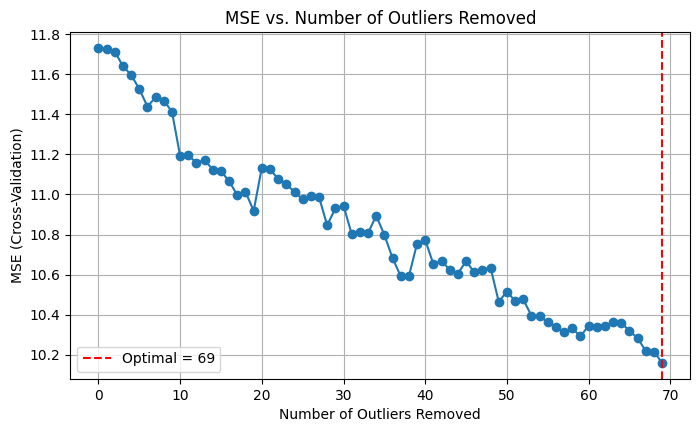

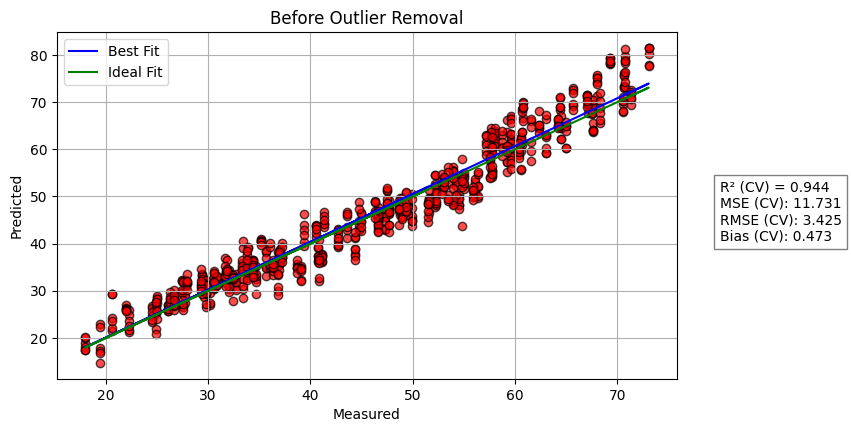

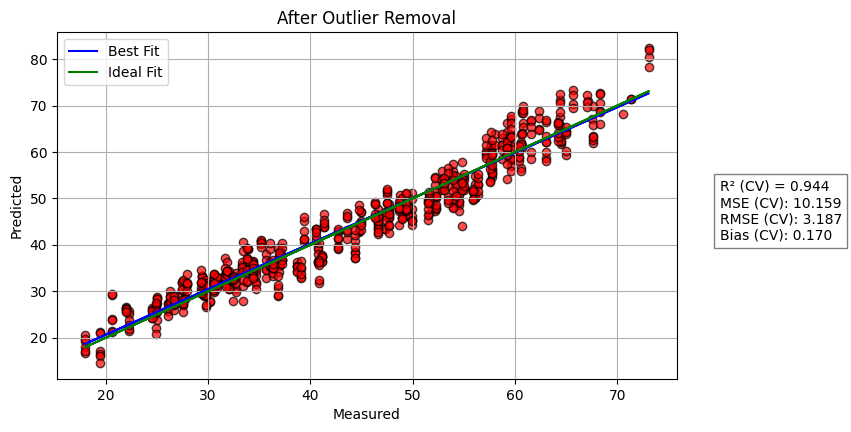

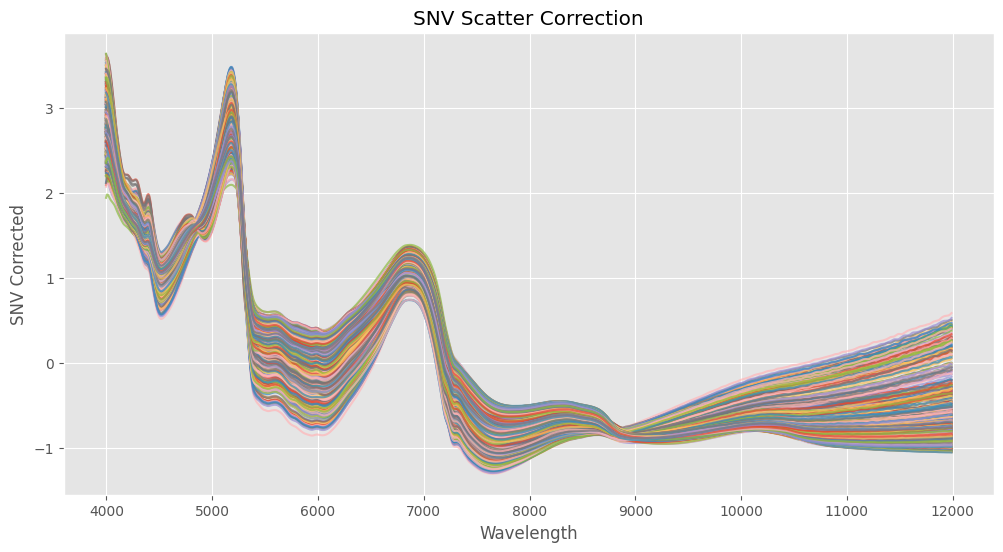

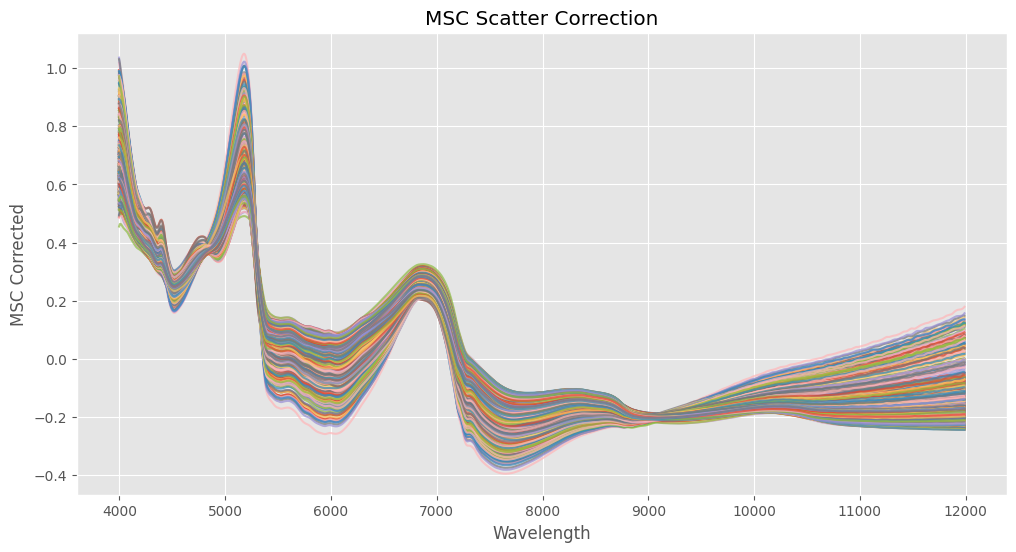

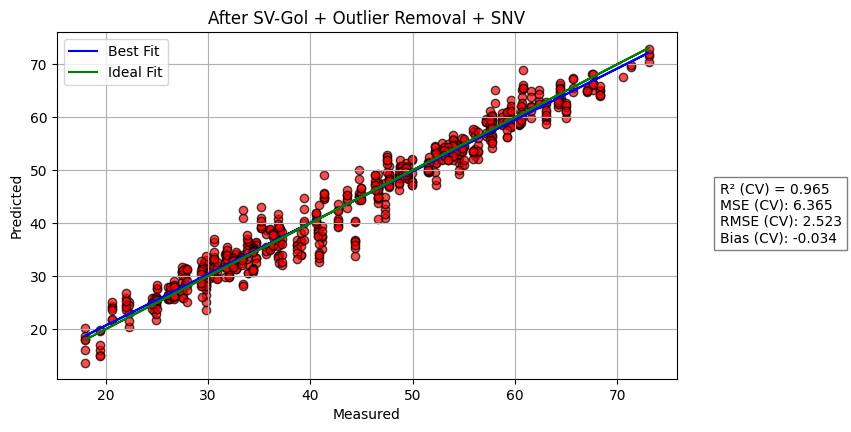

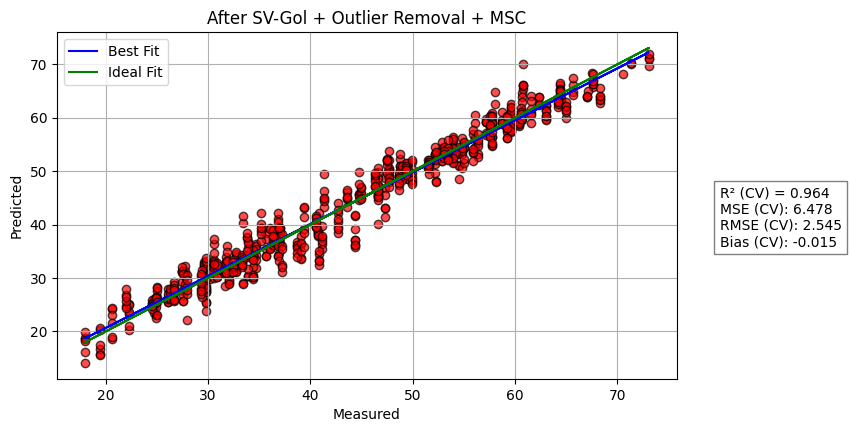

In [19]:
X, y, wl = load_data()

model = PLSRegression
model_params = {"n_components": 14}

process_and_train_model(X, y, wl, "PLS Model", model, model_params)

## 4. SVR Model | SV-GOL Smoothing + Outlier Removal + SNV Correction

100%|██████████| 70/70 [00:29<00:00,  2.36it/s]


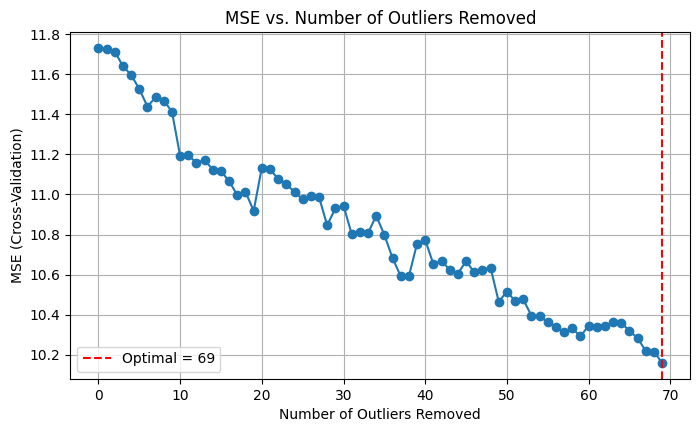

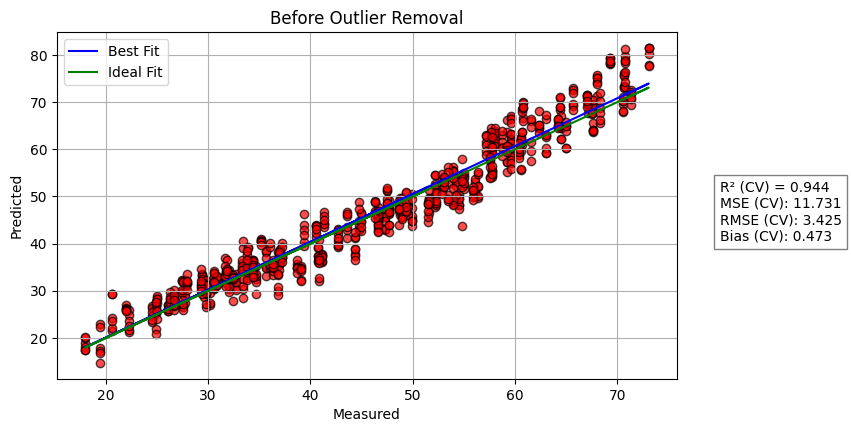

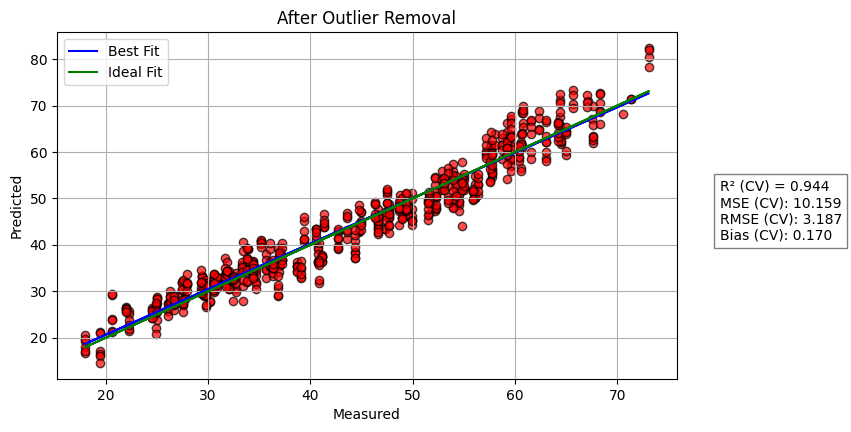

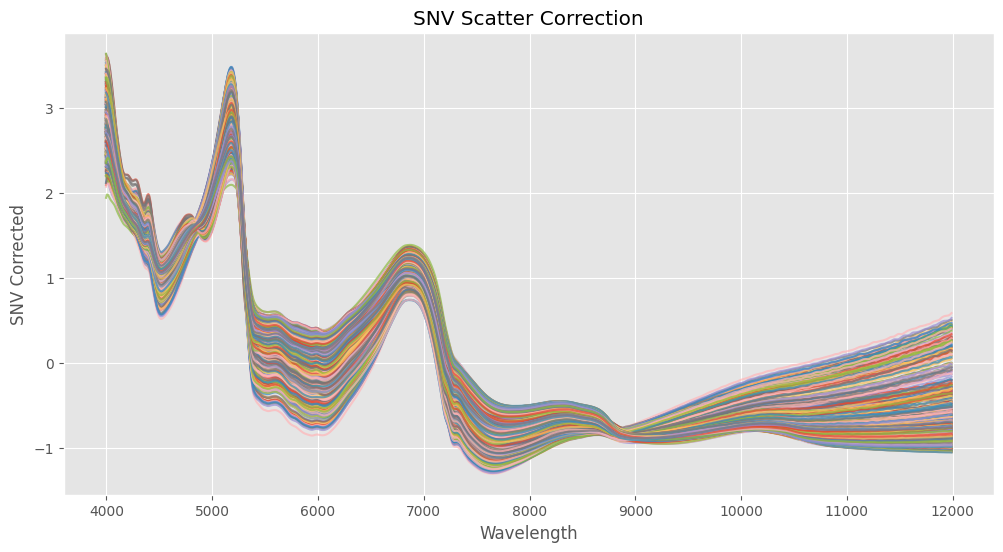

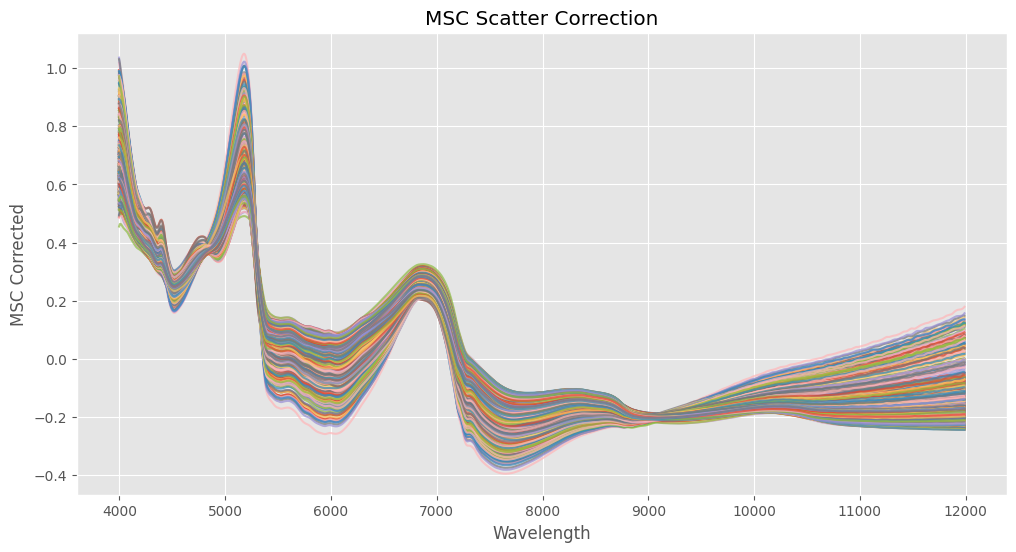

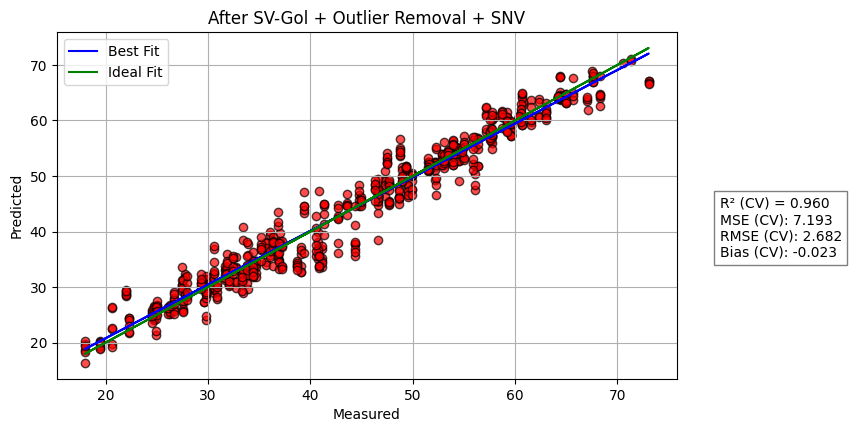

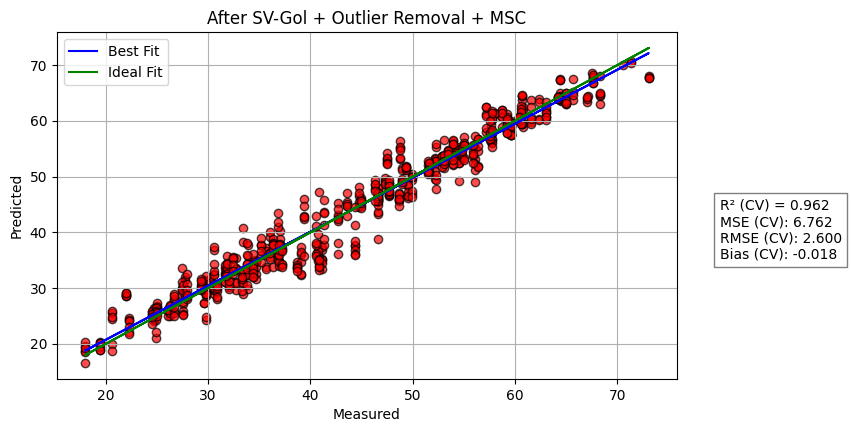

In [20]:
X, y, wl = load_data()

model=SVR
model_params={"kernel": "rbf", "C": 100, "epsilon": 0.01}


process_and_train_model(X, y, wl, "SVR Model", model, model_params)


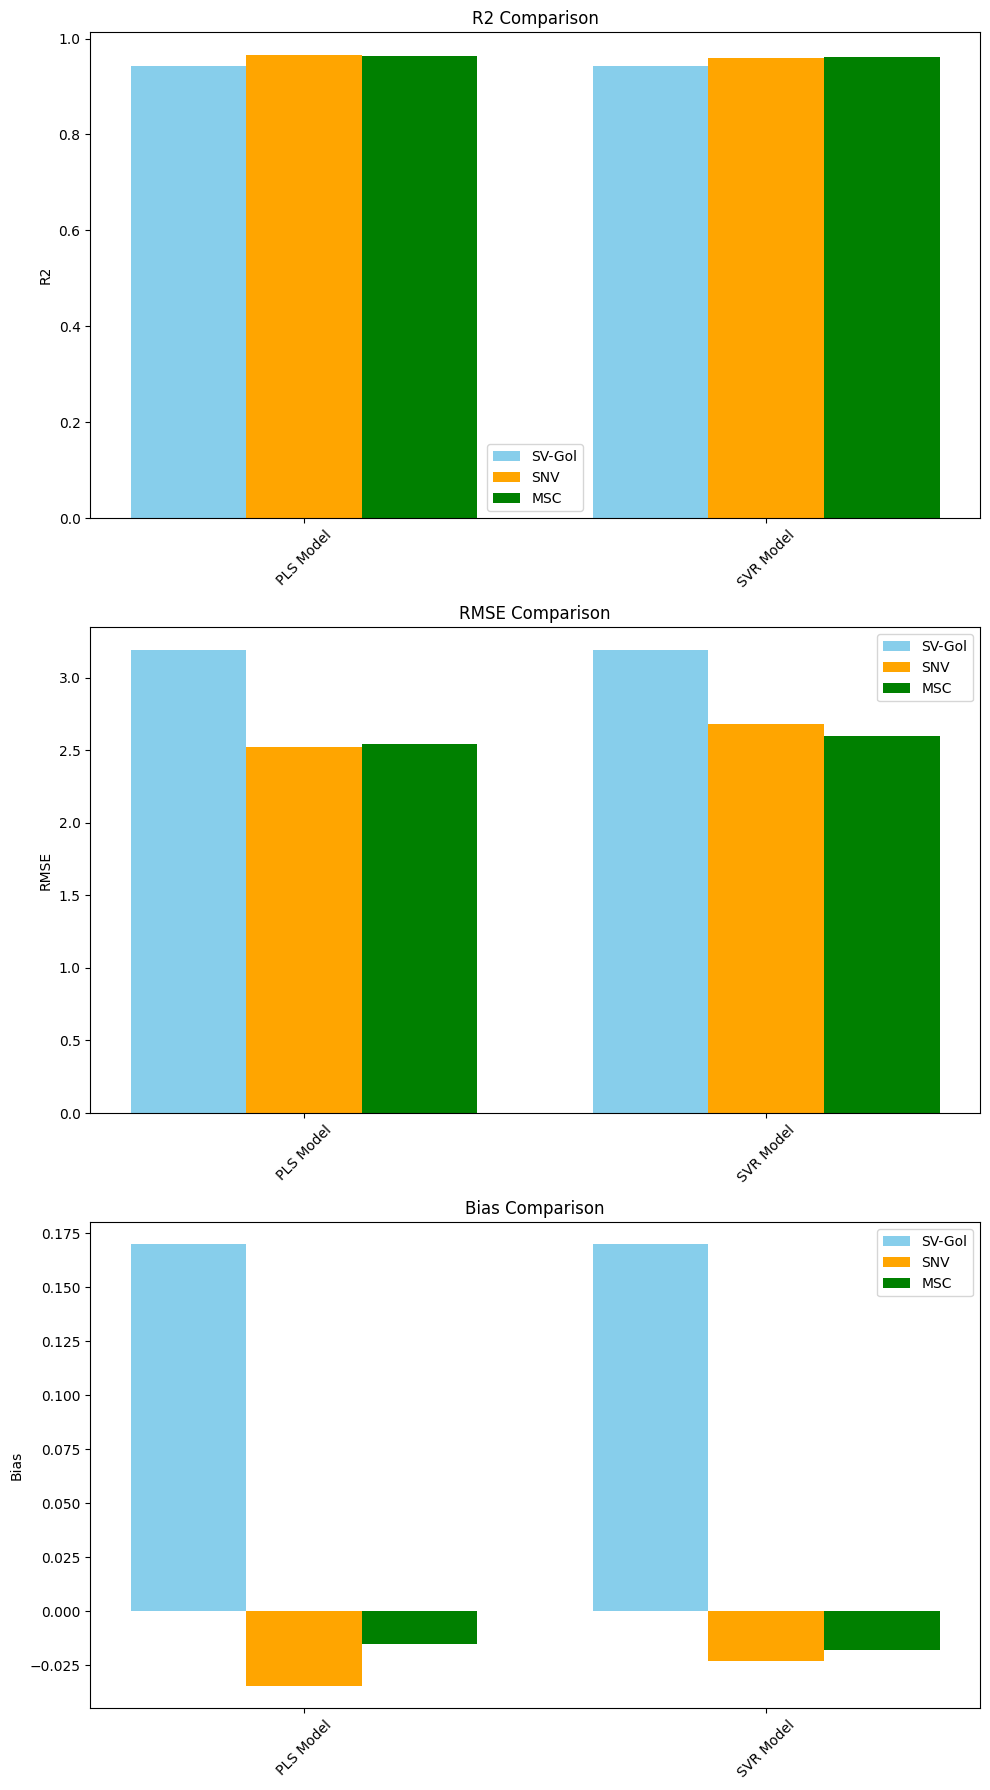

In [21]:
compare_results(results)